In [1]:
pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# 1. Data Loading
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.70MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 55.5MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 6.56MB/s]


In [4]:
# 2. Custom MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

model = MLP().to(device)

In [5]:
# 3. Loss, Optimizer, Metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            total_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader), correct / total

In [6]:
# 4. Training Loop
def train_model(model, train_loader, val_loader, epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        val_loss, val_acc = evaluate(model, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [7]:
# 5. Train
train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, epochs=10)

Epoch 1: Train Loss=0.5406, Train Acc=0.8025, Val Loss=0.4081, Val Acc=0.8517
Epoch 2: Train Loss=0.4078, Train Acc=0.8505, Val Loss=0.3826, Val Acc=0.8609
Epoch 3: Train Loss=0.3703, Train Acc=0.8621, Val Loss=0.3548, Val Acc=0.8705
Epoch 4: Train Loss=0.3506, Train Acc=0.8706, Val Loss=0.3768, Val Acc=0.8614
Epoch 5: Train Loss=0.3306, Train Acc=0.8763, Val Loss=0.3500, Val Acc=0.8683
Epoch 6: Train Loss=0.3169, Train Acc=0.8829, Val Loss=0.3468, Val Acc=0.8717
Epoch 7: Train Loss=0.3075, Train Acc=0.8864, Val Loss=0.3399, Val Acc=0.8798
Epoch 8: Train Loss=0.2930, Train Acc=0.8913, Val Loss=0.3186, Val Acc=0.8847
Epoch 9: Train Loss=0.2853, Train Acc=0.8941, Val Loss=0.3235, Val Acc=0.8826
Epoch 10: Train Loss=0.2732, Train Acc=0.8982, Val Loss=0.3120, Val Acc=0.8900


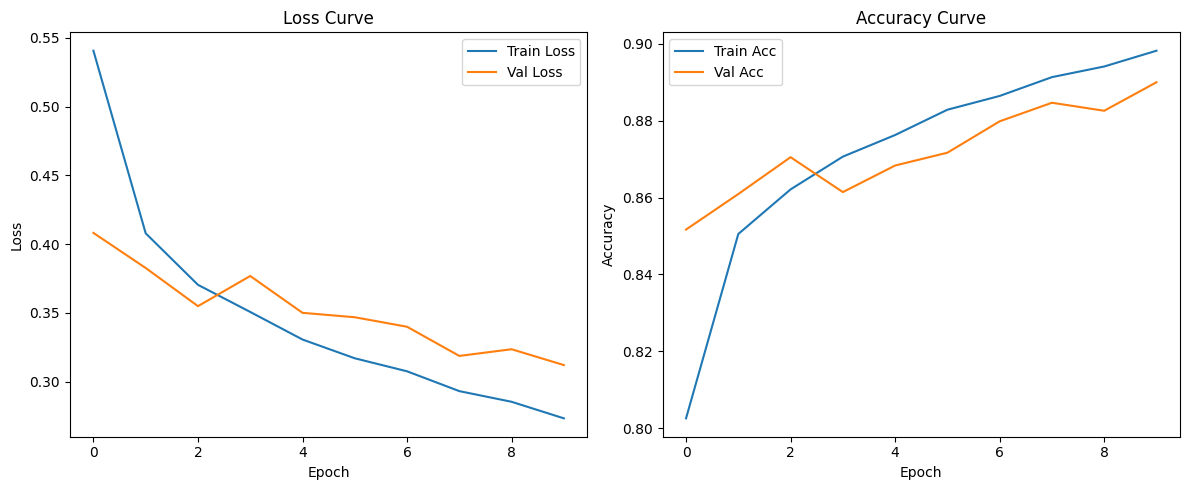

Test Accuracy: 0.8787, Test Loss: 0.3460


In [8]:
# 6. Save model
os.makedirs("saved_models", exist_ok=True)
torch.save(model.state_dict(), "saved_models/fashion_mnist_mlp.pth")

# 7. Load model (for inference or reuse)
def load_model(path):
    model = MLP().to(device)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# 8. Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.tight_layout()
plt.show()

# 9. Final test accuracy
model = load_model("saved_models/fashion_mnist_mlp.pth")
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Test Accuracy: 0.8787, Test Loss: 0.3460

Classification Report:

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.87      0.84      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.79      0.82      0.80      1000
       Dress       0.90      0.86      0.88      1000
        Coat       0.81      0.77      0.79      1000
      Sandal       0.97      0.94      0.95      1000
       Shirt       0.70      0.69      0.69      1000
     Sneaker       0.90      0.97      0.93      1000
         Bag       0.95      0.98      0.96      1000
  Ankle boot       0.97      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



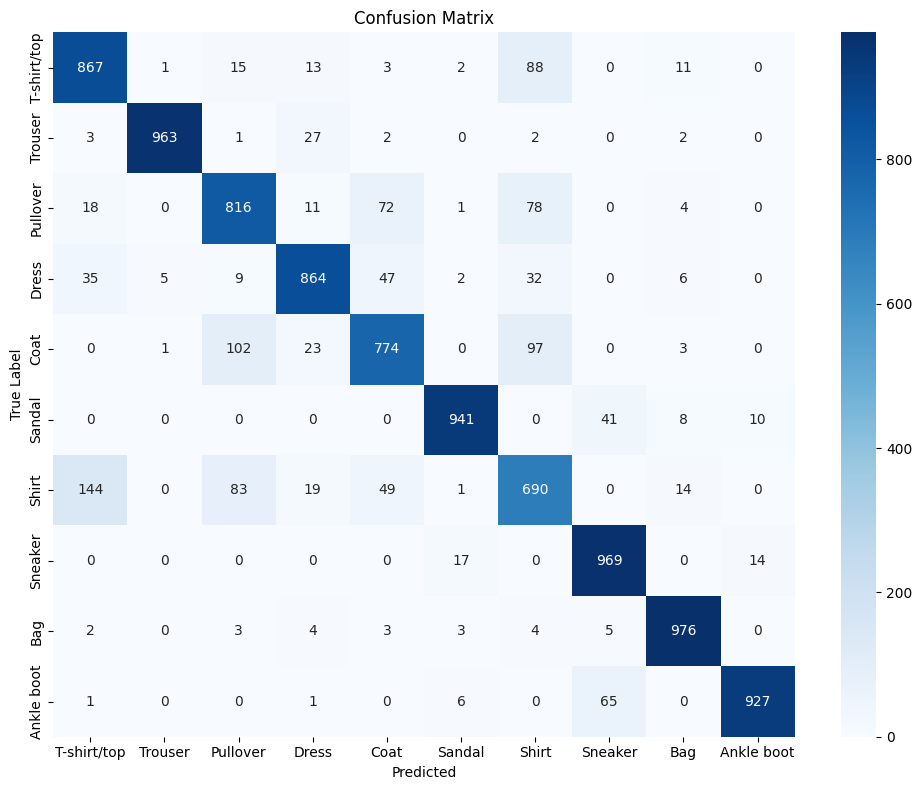

In [14]:
# 9. Detailed evaluation function
def evaluate_detailed(model, data_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# 10. Final test evaluation and detailed report
model = load_model("saved_models/fashion_mnist_mlp.pth")
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

evaluate_detailed(model, test_loader, class_names)